<a href="https://colab.research.google.com/github/trnhan251/bert-based-model/blob/main/BERT_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install and setup

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers
import seaborn as sns

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!curl -LO https://raw.githubusercontent.com/MohamadMerchant/SNLI/master/data.tar.gz
!tar -xvzf data.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.1M  100 11.1M    0     0  91.7M      0 --:--:-- --:--:-- --:--:-- 92.4M
SNLI_Corpus/
SNLI_Corpus/snli_1.0_dev.csv
SNLI_Corpus/snli_1.0_train.csv
SNLI_Corpus/snli_1.0_test.csv


# 2. Exploratory Data Analysis

In [ ]:
# There are more than 550k samples in total; we will use 100k for this example.
train_df = pd.read_csv("SNLI_Corpus/snli_1.0_train.csv")
valid_df = pd.read_csv("SNLI_Corpus/snli_1.0_dev.csv")
test_df = pd.read_csv("SNLI_Corpus/snli_1.0_test.csv")

# Shape of the data
print(f"Total train samples : {train_df.shape[0]}")
print(f"Total validation samples: {valid_df.shape[0]}")
print(f"Total test samples: {test_df.shape[0]}")

Total train samples : 550152
Total validation samples: 10000
Total test samples: 10000


In [ ]:
train_df.count()

similarity    550152
sentence1     550152
sentence2     550146
dtype: int64

In [ ]:
train_df.dropna(subset=['sentence2'], inplace=True)
train_df.count()

similarity    550146
sentence1     550146
sentence2     550146
dtype: int64

In [ ]:
train_df[['similarity']].value_counts()

similarity   
entailment       183414
contradiction    183185
neutral          182762
-                   785
dtype: int64

In [ ]:
train_df.head()

,similarity,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


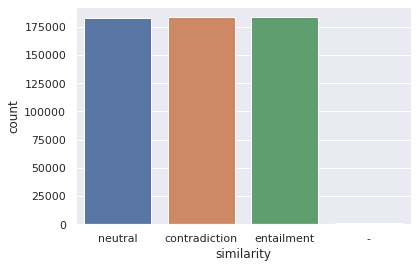

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=train_df)

In [ ]:
train_df.loc[train_df['similarity'] == 'neutral']

,similarity,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
3,neutral,Children smiling and waving at camera,They are smiling at their parents
8,neutral,A boy is jumping on skateboard in the middle o...,The boy is wearing safety equipment.
9,neutral,An older man sits with his orange juice at a s...,An older man drinks his juice as he waits for ...
11,neutral,An older man sits with his orange juice at a s...,An elderly man sits in a small shop.
...,...,...,...
550137,neutral,A group of four kids stand in front of a statu...,the kids are black
550142,neutral,a kid doing tricks on a skateboard on a bridge,a kid is on the golden gate bridge
550145,neutral,A dog with a blue collar plays ball outside.,a dog is chasing a ball
550148,neutral,Four dirty and barefooted children.,"four homeless children had their shoes stolen,..."


# 3. Create new training, validation and test data sets

## 3.1. New training data

In [ ]:
# Train data
contradiction_train_df = train_df.loc[train_df['similarity'] == 'contradiction']
contradiction_train_df = contradiction_train_df.iloc[:91707]

neutral_train_df = train_df.loc[train_df['similarity'] == 'neutral']
neutral_train_df = neutral_train_df.iloc[:91707]

entailment_train_df = train_df.loc[train_df['similarity'] == 'entailment']
entailment_train_df = entailment_train_df.iloc[:183414]

train_df = pd.concat([contradiction_train_df, neutral_train_df, entailment_train_df])
train_df = train_df.sample(frac = 1)
train_df["label"] = train_df["similarity"].apply(
    lambda x: 0 if (x == "contradiction" or x == "neutral") else 1
)

train_labels = tf.keras.utils.to_categorical(train_df.label, num_classes=2)

train_df[['similarity']].value_counts()

similarity   
entailment       183414
neutral           91707
contradiction     91707
dtype: int64

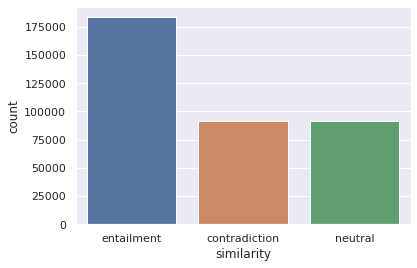

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=train_df)

## 3.2. New validation data

In [ ]:
# Validation data
contradiction_valid_df = valid_df.loc[valid_df['similarity'] == 'contradiction']
contradiction_valid_df = contradiction_valid_df.iloc[:1664]

neutral_valid_df = valid_df.loc[valid_df['similarity'] == 'neutral']
neutral_valid_df = neutral_valid_df.iloc[:1664]

entailment_valid_df = valid_df.loc[valid_df['similarity'] == 'entailment']
entailment_valid_df = entailment_valid_df.iloc[:3328]

valid_df = pd.concat([contradiction_valid_df, neutral_valid_df, entailment_valid_df])
valid_df = valid_df.sample(frac = 1)
valid_df["label"] = valid_df["similarity"].apply(
    lambda x: 0 if (x == "contradiction" or x == "neutral") else 1
)
valid_labels = tf.keras.utils.to_categorical(valid_df.label, num_classes=2)

valid_df[['similarity']].value_counts()

similarity   
entailment       3328
neutral          1664
contradiction    1664
dtype: int64

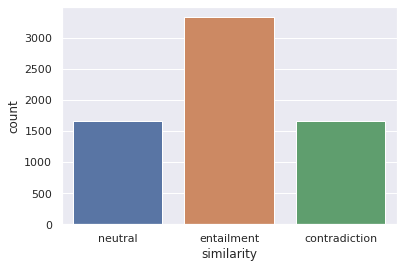

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=valid_df)

## 3.3. New test data

In [ ]:
# Test data
contradiction_test_df = test_df.loc[test_df['similarity'] == 'contradiction']
contradiction_test_df = contradiction_test_df.iloc[:1684]

neutral_test_df = test_df.loc[test_df['similarity'] == 'neutral']
neutral_test_df = neutral_test_df.iloc[:1684]

entailment_test_df = test_df.loc[test_df['similarity'] == 'entailment']
entailment_test_df = entailment_test_df.iloc[:3368]

test_df = pd.concat([contradiction_test_df, neutral_test_df, entailment_test_df])
test_df = test_df.sample(frac = 1) 
test_df["label"] = test_df["similarity"].apply(
    lambda x: 0 if (x == "contradiction" or x == "neutral") else 1
)

test_labels = tf.keras.utils.to_categorical(test_df.label, num_classes=2)

test_df[['similarity']].value_counts()

similarity   
entailment       3368
neutral          1684
contradiction    1684
dtype: int64

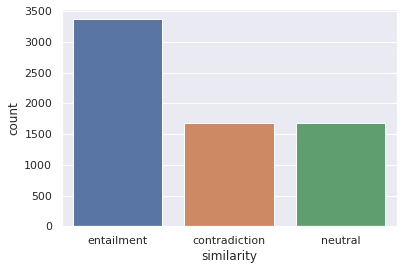

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="similarity", data=test_df)

# 4. Tokenizer

In [ ]:
max_length = 128  # Maximum length of input sentence to the model.
batch_size = 32
epochs = 2

# Labels in our dataset.
labels = ["False", "True"]

In [ ]:

class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        sentence_pairs: Array of premise and hypothesis input sentences.
        labels: Array of labels.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the labels.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], labels)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        sentence_pairs,
        labels,
        batch_size=batch_size,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-uncased", do_lower_case=True
        )
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        # With BERT tokenizer's batch_encode_plus batch of both the sentences are
        # encoded together and separated by [SEP] token.
        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_tensors="tf",
        )

        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        # Set to true if data generator is used for training/validation.
        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)


# 5. Create the model

In [ ]:
# Create the model under a distribution strategy scope.
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Encoded token ids from BERT tokenizer.
    input_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    # Attention masks indicates to the model which tokens should be attended to.
    attention_masks = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="attention_masks"
    )
    # Token type ids are binary masks identifying different sequences in the model.
    token_type_ids = tf.keras.layers.Input(
        shape=(max_length,), dtype=tf.int32, name="token_type_ids"
    )
    # Loading pretrained BERT model.
    bert_model = transformers.TFBertModel.from_pretrained("bert-base-uncased")
    # Freeze the BERT model to reuse the pretrained features without modifying them.
    bert_model.trainable = False

    bert_outputs = bert_model(
        input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
    )
    last_hidden_state = bert_outputs[0]
    
    # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
    bi_lstm = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(last_hidden_state)
    # Applying hybrid pooling approach to bi_lstm sequence output.
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(2, activation="softmax")(dropout)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks, token_type_ids], outputs=output
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["acc"],
    )


print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7f038acb4250>
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]          

In [ ]:
train_data = BertSemanticDataGenerator(
    train_df[["sentence1", "sentence2"]].values.astype("str"),
    train_labels,
    batch_size=batch_size,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    valid_df[["sentence1", "sentence2"]].values.astype("str"),
    valid_labels,
    batch_size=batch_size,
    shuffle=False,
)

# 6. Train model

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch 1/2
11463/11463 [==============================] - ETA: 0s - loss: 0.3826 - acc: 0.8284

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


11463/11463 [==============================] - 3607s 313ms/step - loss: 0.3826 - acc: 0.8284 - val_loss: 0.2617 - val_acc: 0.8930
Epoch 2/2
11463/11463 [==============================] - 3579s 312ms/step - loss: 0.3116 - acc: 0.8706 - val_loss: 0.2492 - val_acc: 0.9011


In [ ]:
output_dir = './gdrive/MyDrive/nlp-model-4'
model.save_weights(output_dir + '/model.h5')

# 7. Fine-tuning model

In [ ]:
# Unfreeze the bert_model.
bert_model.trainable = True
# Recompile the model to make the change effective.
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_masks[0][0]      

In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs,
    use_multiprocessing=True,
    workers=-1,
)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


11463/11463 [==============================] - 9384s 817ms/step - loss: 0.2587 - accuracy: 0.8979 - val_loss: 0.1810 - val_accuracy: 0.9316
Epoch 2/2
11463/11463 [==============================] - 9363s 817ms/step - loss: 0.1860 - accuracy: 0.9313 - val_loss: 0.1805 - val_accuracy: 0.9331


# 8. Evaluate model on the test set

In [ ]:
test_data = BertSemanticDataGenerator(
    test_df[["sentence1", "sentence2"]].values.astype("str"),
    test_labels,
    batch_size=batch_size,
    shuffle=False,
)
model.evaluate(test_data, verbose=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


210/210 [==============================] - 59s 279ms/step - loss: 0.1909 - accuracy: 0.9257


[0.1909422129392624, 0.9257440567016602]

# 9. Custom data evaluation

In [ ]:
def check_similarity(sentence1, sentence2):
    sentence_pairs = np.array([[str(sentence1), str(sentence2)]])
    test_data = BertSemanticDataGenerator(
        sentence_pairs, labels=None, batch_size=1, shuffle=False, include_targets=False,
    )

    proba = model.predict(test_data)[0]
    return {'False': proba[0], 'True': proba[1]}

In [ ]:
sentence1 = "Two women are observing something together."
sentence2 = "Two women are observing something together."
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.014487369, 'True': 0.9855127}

In [ ]:
sentence1 = 'A group of kids is playing in a yard and an old man is standing in the background'
sentence2 = 'A group of boys in a yard is playing and a man is standing in the background'
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.96088, 'True': 0.03912004}

In [ ]:
sentence1 = 'A distributed system is a system from multiple computers which communicate with each other via network'
sentence2 = 'A distributed system is a system from one computer without network'
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.9961546, 'True': 0.00384537}

In [ ]:
sentence1 = 'Bubble sort is a simple sorting algorithm that repeatedly steps through the list, compares adjacent elements and swaps them if they are in the wrong order.'
sentence2 = 'Bubble sort is circle of people'
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.9818125, 'True': 0.018187536}

In [ ]:
sentence1 = "Microservice architecture – a variant of the service-oriented architecture (SOA) structural style – arranges an application as a collection of loosely coupled services. In a microservices architecture, services are fine-grained and the protocols are lightweight."
sentence2 = "Microservice architecture is an art, which has one person"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.9369208, 'True': 0.06307915}

In [ ]:
sentence1 = "People are sitting there. They are watching football"
sentence2 = "People are standing there to watch football"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.99637467, 'True': 0.003625292}

In [ ]:
sentence1 = "A distributed system is a system whose components are located on different networked computers, which communicate and coordinate their actions by passing messages to one another from any system. The components interact with one another in order to achieve a common goal. Three significant characteristics of distributed systems are: concurrency of components, lack of a global clock, and independent failure of components. Examples of distributed systems vary from SOA-based systems to massively multiplayer online games to peer-to-peer applications."
sentence2 = "A distributed system is a system from one computer without network"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.560818, 'True': 0.43918204}

In [ ]:
sentence1 = "A beautiful girl is sitting there"
sentence2 = "A distributed system is a system from one computer without network"
check_similarity(sentence1, sentence2)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'False': 0.97933656, 'True': 0.020663492}

# 10. Save model

In [ ]:
output_dir = './gdrive/MyDrive/nlp-model-4'
model.save_weights(output_dir + '/fine-tuned-model.h5')